### Import libraries

In [5]:
import os
from pathlib import Path
import sys
sys.path.append("../src")
from utils import *

from typing import Tuple, Dict, List
from timeit import default_timer as timer
import random
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

print(torch.__version__)

2.0.0


In [6]:
SEED = 42

Setup device

In [7]:
device = get_device()
print(device)

mps


### Get data
This is the food 101 dataset, which has 101 different classes of food, and 1000 images per class (750-250 train-test split). The dataset used here starts with only 3 classes of food and only 10% of the images to speed up the experiment.

In [8]:
import requests
import zipfile

data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists. Skipping download...")
else:
    print(f"Creating {image_path} directory...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi data...")
    f.write(request.content)

# Unzip zip folder
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping pizza_steak_sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists. Skipping download...
Unziping pizza_steak_sushi data...


### Exploratory data analysis

In [9]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.


The number of sushi, steak and pizza images differ but not to the extent that the data distribution is too skewed.

In [10]:
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image path: data/pizza_steak_sushi/train/sushi/1957449.jpg
Image class: sushi
Image width x height: 512 x 512


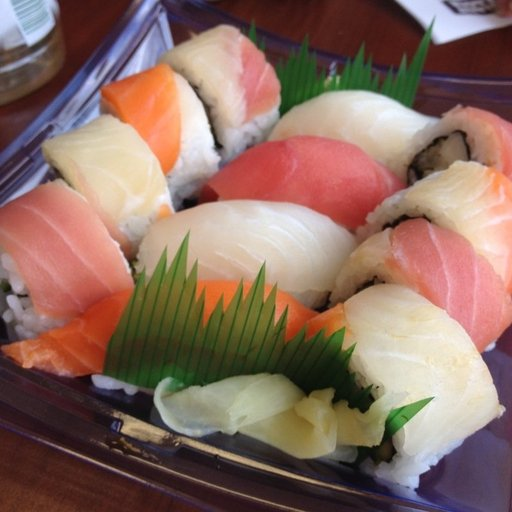

In [11]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Visualize random image
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width x height: {img.width} x {img.height}")
img

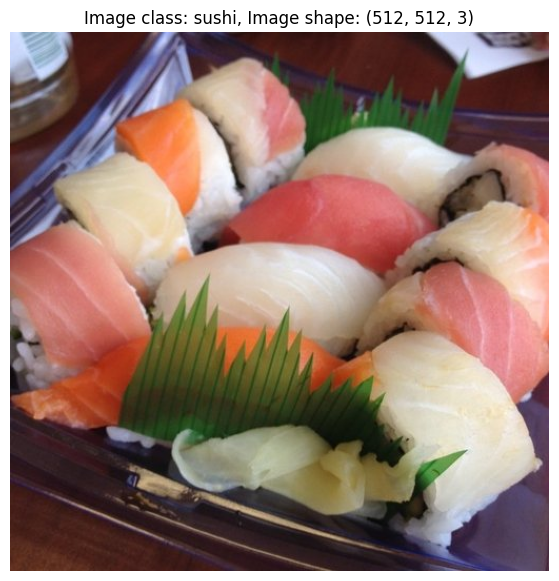

In [12]:
img_as_array = np.asarray(img)
plt.figure(figsize =(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}, Image shape: {img_as_array.shape}")
plt.axis(False)
plt.show()

### Convert images to tensors
* Resize images to 64x64 for our mini VGG model
* Data augmentation
* Convert image to tensor

In [13]:
data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

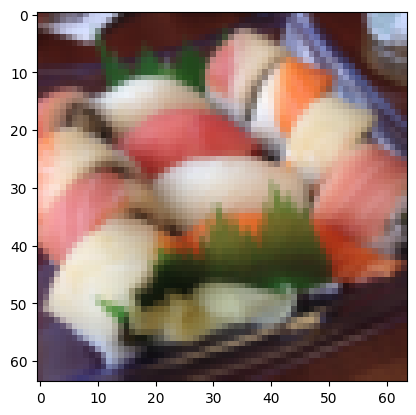

In [14]:
plt.imshow(data_transform(img).permute(1,2,0))

This is a flipped, resized version of the original image

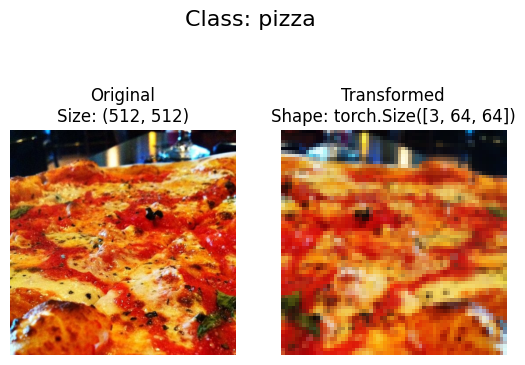

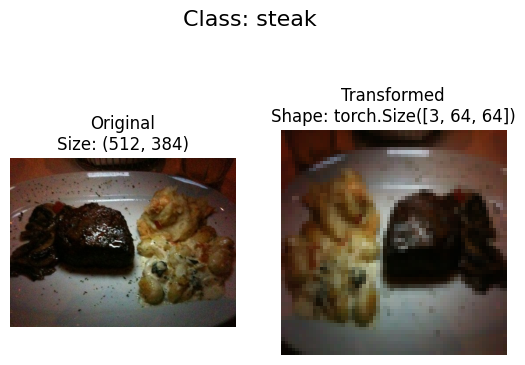

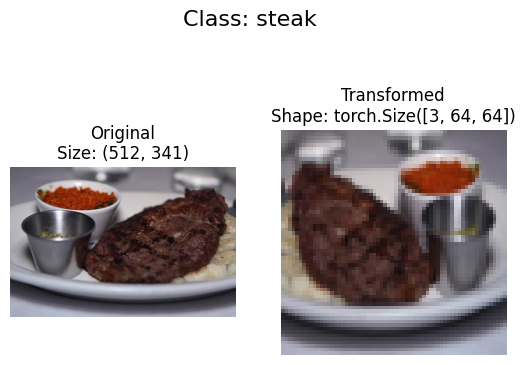

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed = SEED):
    """Transforms images and plots the transformed images
    with the original
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1,2,0))
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_path_list, data_transform)

### Option 1: Load image using `ImageFolder`

In [16]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, #transform for the data
                                  target_transform = None #transform for the label
                                  )

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

We do not need to transform the target because the folder name is the target

In [17]:
# Get class names
class_dict = {v:k for k, v in train_data.class_to_idx.items()}
class_dict

{0: 'pizza', 1: 'steak', 2: 'sushi'}

In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

Visualize sample from train dataset

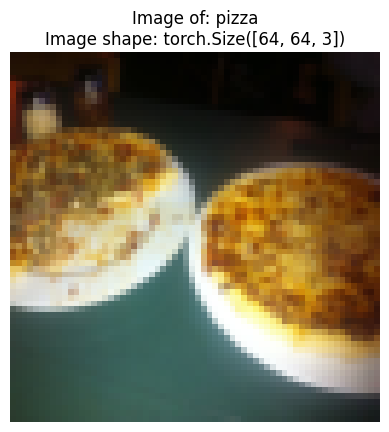

In [20]:
img, label = train_data[0][0], train_data[0][1]
plt.imshow(img.permute(1,2,0))
plt.title(f"Image of: {class_dict[label]}\nImage shape: {img.permute(1,2,0).shape}")
plt.axis(False)
plt.show()

### Turn loaded images into `dataloaders`
A dataloader turns our dataset into iterables

In [21]:
os.cpu_count()

10

I have 10 cpus. But there is no need to use all 10 of them.

In [22]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1, #or os.cpu_count()
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2b2f7d7b0>,
 <torch.utils.data.dataloader.DataLoader at 0x2b2f7d660>)

In [23]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> batch_size, color_channels, height, width")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> batch_size, color_channels, height, width
Label shape: torch.Size([1])


### Option 2: Use `Custom Dataset`
The advantage of doing this is that you can add customizability.

In [24]:
target_directory = train_dir
sorted(entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir())

['pizza', 'steak', 'sushi']

In [25]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [26]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Use os.scandir() to traverse a target directory and get class names
    Turn class names into a dict and returns it
    """
    classes = sorted(entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}...\nPlease check file structure")
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Create a custom dataset to replace `ImageFolder`

In [28]:
class ImageFolderCustom(torch.utils.data.Dataset):
    """Custom dataset object
    """
    def __init__(self, target_directory: str = None, transform = None):
        """Class constructor. Takes in a target directory filepath and
        optionally a torch transform.
        """
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_directory)
        self.paths = list(Path(target_directory).glob("*/*.jpg"))
    def load_image(self, index: int) -> Image.Image:
        """Opens an image given a path and returns it
        """
        image_path = self.paths[index]
        return Image.open(image_path)
    def __len__(self):
        """Returns total number of samples
        """
        return len(self.paths)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Overrides __getitem__ method to return a particular sample
        Returns one sample of data -> X and y. If a transform is specified,
        returns the transformed image and label. Otherwise, just returns
        original image and label.
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [29]:
# Create train and test transforms
train_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor() 
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory = train_dir,
                                      transform = train_transforms)
test_data_custom = ImageFolderCustom(target_directory = test_dir,
                                     transform = test_transforms)

len(train_data_custom), len(test_data_custom)

(225, 75)

In [31]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### Create function to display random images
Takes in a `dataset` and other parameters such as class names and how many images to visualize. Set random seed for reproducibility.

In [32]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = SEED): 
    """Displays random images
    """
    if n>10:
        n = 10
        display_shape = False
        print(f"For display purposes, n should not be larger than 10. Setting to 10 and removing shaped display..")
    if seed:
        random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k = n)
    
    plt.figure(figsize = (20,10))
    for i, sample in enumerate(random_samples_idx):
        image, label = dataset[sample][0], dataset[sample][1]
        image_plot = image.permute(1,2,0)
        plt.subplot(1, n, i+1)
        plt.imshow(image_plot)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[label]}"
            if display_shape:
                title = title + f"\nshape: {image_plot.shape}"
            plt.title(title)

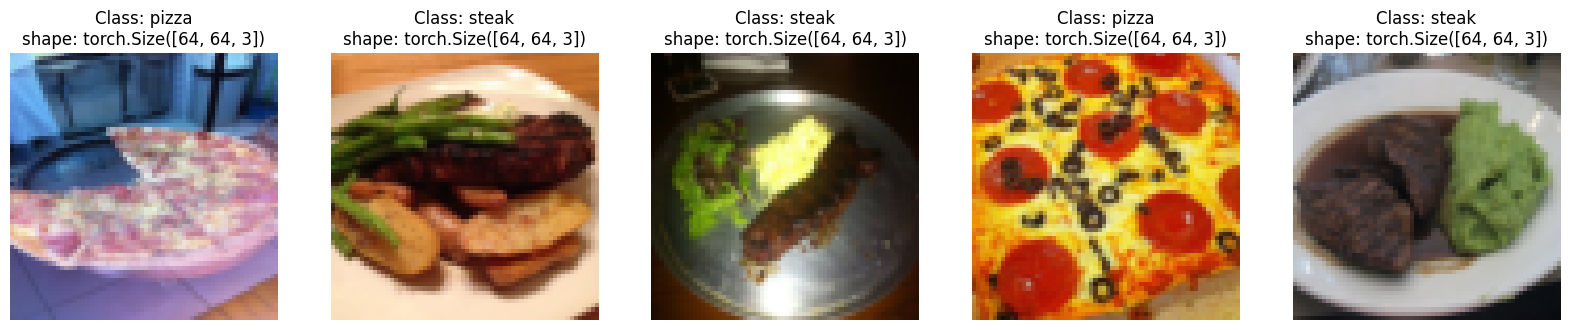

In [33]:
display_random_images(train_data_custom, classes = train_data_custom.classes, n = 5)

Turn custom datasets into dataloaders

In [34]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                              batch_size = BATCH_SIZE,
                              num_workers = 0,
                              shuffle = True)
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                             batch_size = BATCH_SIZE,
                             num_workers = 0,
                             shuffle = False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2941efee0>,
 <torch.utils.data.dataloader.DataLoader at 0x17670c280>)

In [35]:
#Get image and label from dataloader
img, label = next(iter(train_dataloader_custom))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

#### Data augmentation
Let's look at trivial augment - it applies a random data augmentation to the dataset. The PyTorch team has used this transformation to enhance SOTA mdoels. https://arxiv.org/abs/2103.10158
> Artificially adding diversity to training data so that the model doesn't "memorize" the image but learns generalizable features from the image to better predict on unseen data.

In [36]:
custom_train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5), #the augmentation's intensity is between 0-5
    transforms.ToTensor()
])
custom_test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [37]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

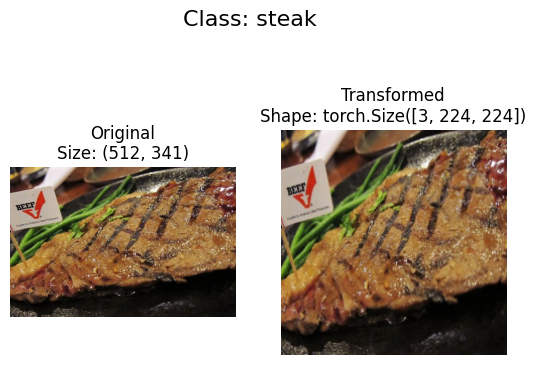

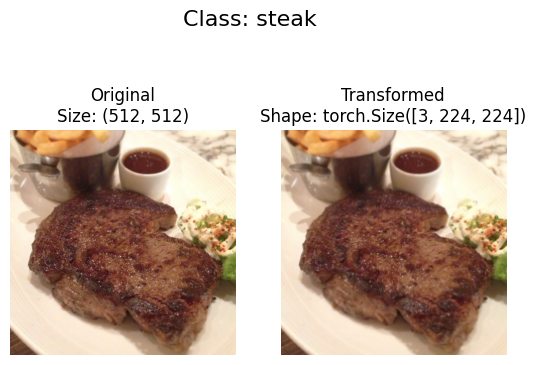

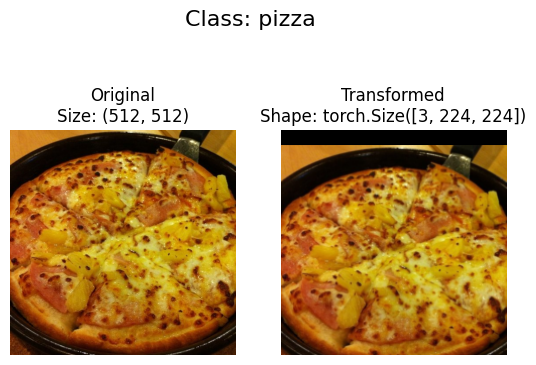

In [38]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = custom_train_transform,
    n = 3,
    seed = None
)

### Building baseline model (model0): TinyVGG without data augmentation

In [39]:
# Create transforms and load data for model 0
simple_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

train_data_simple = datasets.ImageFolder(root = train_dir, 
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir, 
                                        transform = simple_transform)


BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)
test_dataloader_simple = DataLoader(test_data_simple,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = False)

In [65]:
class TinyVGG(nn.Module):
    """Reference: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, 
                 input_shape: int, 
                 hidden_units: int, 
                 output_shape:int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, 
                         stride = 2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, 
                         stride = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 13 * 13,
                      out_features = output_shape)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x
        

In [66]:
torch.manual_seed(SEED)
model0 = TinyVGG(input_shape = 3, #number of color channels
                 hidden_units = 10, #same as the tinyVGG architecture
                 output_shape = 3 #number of classes
                 ).to(device)
model0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [42]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

Try a forward pass

In [67]:
x = model0(image_batch.to(device))
x.shape

torch.Size([32, 3])

In [68]:
!pip install torchinfo


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [69]:
import torchinfo
from torchinfo import summary

summary(model0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia